## **Importing the necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import json 
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the given data

The given data is in JSON format and it is required convert it to a dataframe.

In [ ]:
# Opening JSON file 
f = open('/content/sample_data/complaints-2021-05-14_08_16.json')
data = json.load(f) # Converting the file f into json Object named data
df=pd.json_normalize(data) # Flattening the json object into DataFrame.

## Data Pre-processing



In [ ]:
# Get a concise summary of the DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
df.head(20)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A




##Renaming columns as they contain extra '_' before name



In [ ]:
#print the column names
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [ ]:
#Renamning the columns
df.rename(columns={'_index': 'index', '_type': 'type','_id': 'id', '_score':'score','_source.tags': 'tags','_source.zip_code': 'zip_code',
                   '_source.complaint_id': 'complaint_id','_source.issue': 'issue', '_source.date_received': 'date_received',
                   '_source.state':'state', '_source.consumer_disputed':'consumer_disputed', '_source.product':'product',
                   '_source.company_response':'company_response', '_source.company':'company', 
                   '_source.submitted_via':'submitted_via','_source.date_sent_to_company':'date_sent_to_company', 
                   '_source.company_public_response':'company_public_response','_source.sub_product':'sub_product', 
                   '_source.timely':'timely','_source.complaint_what_happened':'complaint_what_happened',
                   '_source.sub_issue':'sub_issue','_source.consumer_consent_provided':'consumer_consent_provided'}, inplace=True)

In [ ]:
#print  the revised column names
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [ ]:
#Assigning nan in place of blanks in the complaints column(complaint_what_happened)
df[df['complaint_what_happened']==''] = np.nan

In [ ]:
#Removing all rows where complaints column is nan
df=df.dropna(subset=['complaint_what_happened'])

In [ ]:
# DataFrame summary after removal of the rows where complaints column is nan
df.info

<bound method DataFrame.info of                      index  ... consumer_consent_provided
1      complaint-public-v2  ...          Consent provided
2      complaint-public-v2  ...          Consent provided
10     complaint-public-v2  ...          Consent provided
11     complaint-public-v2  ...          Consent provided
14     complaint-public-v2  ...          Consent provided
...                    ...  ...                       ...
78303  complaint-public-v2  ...          Consent provided
78309  complaint-public-v2  ...          Consent provided
78310  complaint-public-v2  ...          Consent provided
78311  complaint-public-v2  ...          Consent provided
78312  complaint-public-v2  ...          Consent provided

[21072 rows x 22 columns]>

## Text pre processing for topic modeling





In [ ]:
# Again observing top 20 rows of the DataFrame
df.head(20)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided
15,complaint-public-v2,complaint,3209411,0.0,None,None,3209411,Improper use of your report,2019-04-11T12:00:00-05:00,LA,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-11T12:00:00-05:00,None,Credit reporting,Yes,Can you please remove inquiry,Credit inquiries on your report that you don't...,Consent provided
17,complaint-public-v2,complaint,3331023,0.0,None,770XX,3331023,Closing an account,2019-08-06T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-06T12:00:00-05:00,None,Checking account,Yes,With out notice J.P. Morgan Chase restricted m...,Funds not received from closed account,Consent provided
20,complaint-public-v2,complaint,3352857,0.0,None,207XX,3352857,Struggling to pay your loan,2019-08-24T12:00:00-05:00,MD,N/A,Vehicle loan or lease,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-24T12:00:00-05:00,None,Loan,Yes,"During the summer months, I experience a decli...",Denied request to lower payments,Consent provided
21,complaint-public-v2,complaint,3226110,0.0,Servicemember,846XX,3226110,Fraud or scam,2019-04-29T12:00:00-05:00,UT,N/A,"Money transfer, virtual currency, or money ser...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-29T12:00:00-05:00,None,Domestic (US) money transfer,Yes,"On XXXX XX/XX/2019, I made a {$300.00} payment...",None,Consent provided
23,complaint-public-v2,complaint,3237765,0.0,None,330XX,3237765,Incorrect information on your report,2019-05-09T12:00:00-05:00,FL,N/A,Credit card or prepaid card,Closed with non-monetary relief,JPMORGAN CHASE & CO.,Web,2019-05-09T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have a Chase credit card which is incorrectl...,Account information incorrect,Consent provided


In [ ]:
# Cleaning by converting text to lowercase, removing text in square brackets and removing punctuation and  words containing numbers.
import re, nltk, spacy, string
pd.options.mode.chained_assignment = None  #pandas chained_assignment warning exception handling
df.complaint_what_happened=df.complaint_what_happened.astype(str)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df_clean = pd.DataFrame(df.complaint_what_happened.apply(lambda x: clean_text(x)))

In [ ]:
# Observing the DataFrame after the cleaning
df_clean

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [ ]:
# Defining a function to lemmatize the texts
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [ ]:
#Creating a dataframe that will contain only the complaints and its lemmatized version.
import en_core_web_sm
nlp = en_core_web_sm.load()
df_clean["Complaint_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

In [ ]:
df_clean

,complaint_what_happened,Complaint_lemmatize
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...


In [ ]:
#  Chunking : Extracting phrases from unstructured text, to analyze  sentences in order to identify the constituents
# (Noun Groups, Verbs, verb groups, etc.)
#  Here we are using only noun, singular as we have already lemmatized the texts.
import pandas as pd
from textblob import TextBlob
nltk.download('punkt')
import nltk
nltk.download('all')


def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

def get_NN(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_NN(x['Complaint_lemmatize']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /r

In [ ]:
# Now the dataframe contains the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,i call chas -PRON- credit card provider claim ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer i -PRON- bank app ch...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit yrs credit card chase freedom xxxx prob...


## **Exploratory Data Analysis (EDA)**

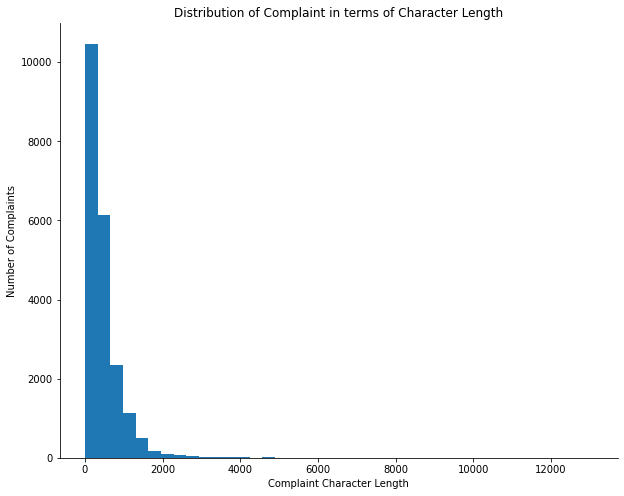

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
plt.figure(figsize=(10,8))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 40)
plt.title('Distribution of Complaint in terms of Character Length')
plt.ylabel('Number of Complaints')
plt.xlabel('Complaint Character Length')
sns.despine();

## In terms of the distribution of the word counts, it is skewed a little positive but overall it is a quite normal distribution

## Observing the top 40 words by frequency among all the articles after processing the text.

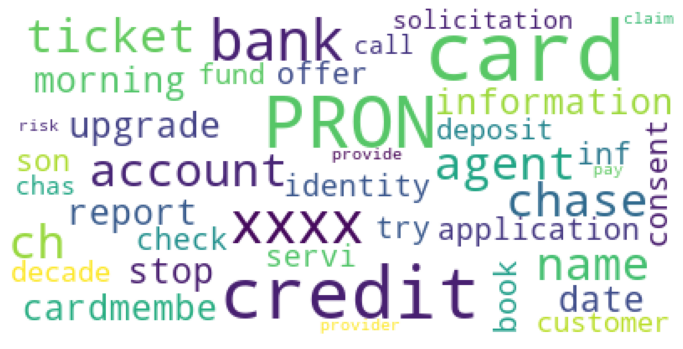

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
def get_top_n_unigrams(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_unigrams(df_clean['Complaint_clean'].values.astype('U'), 50)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 50 unigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [ ]:
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 bigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [ ]:
df2.head(10)

,unigram,count
0,chase,50015
1,account,47168
2,credit,34149
3,xxxx,34013
4,card,29071
5,bank,28392
6,payment,21159
7,time,16025
8,charge,15539
9,day,12970


In [ ]:
df3.head(5)

,bigram,count
0,credit card,12773
1,credit report,3979
2,xxxx xxxx,3451
3,chase bank,3379
4,customer service,3078


In [ ]:
def get_top_n_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 trigrams in the Complaint text"))
fig.show()

In [ ]:
df4.head(5)

,trigram,count
0,chase credit card,2021
1,credit card account,1022
2,credit card company,990
3,credit card chase,644
4,credit card credit,493


In [ ]:
# removing 'xxxx' from data
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...,try book ticket i offer ticket card i informa...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,i call chas -PRON- credit card provider claim ...,i call chas credit card provider claim purcha...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer i -PRON- bank app ch...,pay risk provide consumer i bank app chase ye...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Convert the raw texts to a matrix of TF-IDF features

max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

min_df is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

## Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Non-Negative Matrix Factorization (NMF)

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In [ ]:
from sklearn.decomposition import NMF

## Coherence Model to select the optimum number of Topics
With the Coherence Model we will see how to automatically select the optimum number of topics. 


In [ ]:
!pip install --upgrade gensim
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter
# Use Gensim's NMF to get the optimum num of topics via coherence score
texts = df_clean['Complaint_clean']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics having the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


## Manual Topic Modeling
With the Coherence Model, we got the best number of topics=5 


An important parameter that is required is the number of components i.e. the number of topics we require. 
This is the most crucial step in the whole topic modeling process and will greatly affect how good one's final topics are.

In [ ]:
nmf_model = NMF(n_components=5,random_state=40)

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7401

In [ ]:
#Print the top word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

number
day
branch
deposit
fund
chase
money
check
bank
account


In [ ]:
#Print top 15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'fund', 'chase', 'money', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['car', 'year', 'chase', 'account', 'credit', 'date', 'auto', 'time', 'pay', 'day', 'fee', 'statement', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['company', 'statement', 'time', 'refund', 'service', 'fraud', 'claim', 'purchase', 'merchant', 'dispute', 'transaction', 'chase', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']




In [ ]:
#Creating the best topic for each complaint
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2])

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [ ]:
df_clean.head()

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,4
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...,try book ticket i offer ticket card i informa...,1
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0


In [ ]:
#Print the first 5 complaints for each of the topics
df_dc=df_clean.groupby('Topic').head(5)
df_dc.sort_values('Topic')

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict -PRON...,jp restrict account debit card tuesday thursda...,jp restrict account debit card tuesday thursda...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,i account bank code bonus i term everything ac...,i account bank code bonus i term everything ac...,0
35,i opened the saving account for the bonus i w...,i open the saving account for the bonus i be...,i account bonus i bonus auto transfer check no...,i account bonus i bonus auto transfer check no...,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...,try book ticket i offer ticket card i informa...,1
15,can you please remove inquiry,can -PRON- please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


In [ ]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",1:"Credit card or prepaid card", 2:"Others",3:"Theft/Dispute Reporting",4:"Mortgage/Loan"}

In [ ]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
# Observe the DataFrame
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...,try book ticket i offer ticket card i informa...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,i call chas -PRON- credit card provider claim ...,i call chas credit card provider claim purcha...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer i -PRON- bank app ch...,pay risk provide consumer i bank app chase ye...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,Others


In [ ]:
#mapping topic to class
Topic_names = {"Bank Account services":0,"Credit card or prepaid card":1,"Others":2,"Theft/Dispute Reporting":3,"Mortgage/Loan":4}
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,4
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...,try book ticket i offer ticket card i informa...,1
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,i call chas -PRON- credit card provider claim ...,i call chas credit card provider claim purcha...,3
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer i -PRON- bank app ch...,pay risk provide consumer i bank app chase ye...,3
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,2


In [ ]:
training_data=df_clean[["complaint_what_happened","Topic"]]

In [ ]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer


#GET VECTOR COUNT
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

#SAVE WORD VECTOR
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

#TRANSFORM WORD VECTOR TO TF IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#SAVE TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [ ]:
# Multinomial Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = MultinomialNB().fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("nb_model.pkl", "wb"))

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]

docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("nb_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Mortgage/Loan


In [ ]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card or prepaid card  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Credit card or prepaid card  -  Others
Bank Account services  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Repo

In [ ]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, predicted, target_names=target_names))

[[1186   59    0   46   12]
 [ 164  963    0  155    8]
 [ 142  174    5  132   95]
 [ 203   46    0  950    5]
 [ 117   82    0   24  700]]
                             precision    recall  f1-score   support

      Bank Account services       0.65      0.91      0.76      1303
Credit card or prepaid card       0.73      0.75      0.74      1290
              Mortgage/Loan       1.00      0.01      0.02       548
            Theft Reporting       0.73      0.79      0.76      1204
                     Others       0.85      0.76      0.80       923

                   accuracy                           0.72      5268
                  macro avg       0.79      0.64      0.62      5268
               weighted avg       0.76      0.72      0.68      5268



In [ ]:
# Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("logreg_model.pkl", "wb"))

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]

docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("logreg_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Mortgage/Loan


In [ ]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card or prepaid card  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Others  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute

In [ ]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, predicted, target_names=target_names))

[[1240   19    6   29    9]
 [  21 1197    6   50   16]
 [  11   11  488   14   24]
 [  49   38    7 1089   21]
 [  19   15    4   12  873]]
                             precision    recall  f1-score   support

      Bank Account services       0.93      0.95      0.94      1303
Credit card or prepaid card       0.94      0.93      0.93      1290
              Mortgage/Loan       0.95      0.89      0.92       548
            Theft Reporting       0.91      0.90      0.91      1204
                     Others       0.93      0.95      0.94       923

                   accuracy                           0.93      5268
                  macro avg       0.93      0.92      0.93      5268
               weighted avg       0.93      0.93      0.93      5268



In [ ]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("DT_model.pkl", "wb"))

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]

docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("DT_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Mortgage/Loan


In [ ]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card or prepaid card  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Others  -  Others
Bank Account services  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute Repor

In [ ]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, predicted, target_names=target_names))

[[1028   62   41  128   44]
 [  86 1025   28  108   43]
 [  33   36  410   34   35]
 [ 127  107   33  872   65]
 [  57   22   37   46  761]]
                             precision    recall  f1-score   support

      Bank Account services       0.77      0.79      0.78      1303
Credit card or prepaid card       0.82      0.79      0.81      1290
              Mortgage/Loan       0.75      0.75      0.75       548
            Theft Reporting       0.73      0.72      0.73      1204
                     Others       0.80      0.82      0.81       923

                   accuracy                           0.78      5268
                  macro avg       0.77      0.78      0.78      5268
               weighted avg       0.78      0.78      0.78      5268



In [ ]:
# Random Forest Techniquw

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("RF_model.pkl", "wb"))

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]

docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("RF_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Mortgage/Loan


In [ ]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card or prepaid card  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Credit card or prepaid card  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Report

In [ ]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Bank Account Services","Credit card or Prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, predicted, target_names=target_names))

[[1166  108    0   24    5]
 [  82 1086    0  113    9]
 [ 131  222    8   92   95]
 [ 178  150    0  868    8]
 [  70  139    0   30  684]]
                             precision    recall  f1-score   support

      Bank Account Services       0.72      0.89      0.80      1303
Credit card or Prepaid card       0.64      0.84      0.73      1290
              Mortgage/Loan       1.00      0.01      0.03       548
            Theft Reporting       0.77      0.72      0.74      1204
                     Others       0.85      0.74      0.79       923

                   accuracy                           0.72      5268
                  macro avg       0.80      0.64      0.62      5268
               weighted avg       0.76      0.72      0.69      5268



# Analysis:
Based on the confusion matrix of the classification models, their performance is as under:


***Logistic Regression:*** Accuracy: 0.93, F1 Weighted Average: 0.93

***Naive Bayes:***  Accuracy: 0.72 , F1 Weighted Average: 0.68

***Decision Tree:*** Accuracy   0.78 ,  F1 Weighted Average:  0.78

**Random Forest :** Accuracy   0.72 , F1 Weighted Average:  0.69

Thus LR has the best performance 